For evaluation of ML models weighted absolute percentage error (WAPE) is used as quality metric.

$$\text{WAPE}(y, \hat{y}\ ) = \frac{100\%}{N} \frac{\sum_{}^{}y_i - \hat{y}_i}{\sum_{}^{}y_i}$$

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import catboost as cb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# ignore warnings when graphs are plotted
import warnings

warnings.filterwarnings("ignore")


# define func for WAPE calculation
def wape_f(y_true, y_pred):
    return round(np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100, 3)

## Read data

In [6]:
train_df = pd.read_parquet("../data/train_df.parquet")
eval_df = pd.read_parquet("../data/eval_df.parquet")
test_df = pd.read_parquet("../data/test_df.parquet")

In [7]:
# check data sample
train_df.head(1)

,date,city_name,store_id,category_id,product_id,price,weather_desc,humidity,temperature,pressure,...,month,is_month_start,is_month_end,year,quarter,season,sales_lag_1_week,sales_lag_2_week,sales_lag_3_week,median_lag
21,2021-09-09,Moscow,1,1,1,4.79,partly cloudy,78.9375,15.0625,747.0,...,9,False,False,2021,3,autumn,12.0,23.0,20.0,20.0


## Building ML models

### Optuna

#### CatBoost

In [ ]:
tuning_params_cb = {
    # TODO: add more params for CatBoost
    "int": {
        "n_estimators": [100, 500],
        "depth": [6, 16],
    },
    "float": {
        "learning_rate": [0.1, 0.3],
    },
}

cat_feats = [
    col
    for col in train_df.drop(columns="sales").columns
    if train_df[col].dtype in ("O", "int64", "bool")
]


class WapeMetric:
    def is_max_optimal(self):
        return False  # greater is better

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        y_pred = np.rint(approx).astype(int)
        y_true = np.array(target).astype(int)

        output_weight = 1  # weight is not used

        score = wape_f(y_true, y_pred)

        return score, output_weight

    def get_final_error(self, error, weight):
        return error


default_params_cb = dict(
    # TODO: add more default params for Catboost
    n_estimators=200,
    learning_rate=0.05,
    depth=11,
    random_state=11,
    cat_features=cat_feats,
    eval_metric=WapeMetric(),
)

In [ ]:
def objective(
    trial,
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    tuning_params,
    default_params,
    model_name,
) -> float:

    params = {
        key: trial.suggest_int(key, *value)
        for key, value in tuning_params["int"].items()
    }
    params.update(
        {
            key: trial.suggest_float(key, *value, log=True)
            for key, value in tuning_params["float"].items()
        }
    )
    params.update(
        {nm: value for nm, value in default_params.items() if nm not in params.keys()}
    )

    if model_name == "cb":
        model = cb.CatBoostRegressor(**params)
    elif model_name == "lgb":
        model = lgb.LGBMRegressor(**params)

    model.fit(
        X=train_df.drop(columns="sales"),
        y=train_df.sales,
    )

    y_pred = model.predict(test_df.drop(columns="sales"))

    metric = wape_f(test_df.sales, y_pred)

    return metric

In [ ]:
optuna_cut_date = str(train_df.date.max() - pd.DateOffset(days=6))[:10]
optuna_train_df = (
    train_df[(train_df.date < optuna_cut_date)]
    .drop(columns=["date"])
    .reset_index(drop=True)
)
optuna_test_df = (
    train_df[(train_df.date >= optuna_cut_date)]
    .drop(columns=["date"])
    .reset_index(drop=True)
)

In [ ]:
study = optuna.create_study(direction="minimize", study_name=f"CatBoost Tunning")

# with ThreadPoolExecutor(self.n_trials_optuna) as pool:
#     for _ in range(self.n_trials_optuna):

#         obj_function = lambda trial: self._objective(
#             trial,
#             train_df=train_df,
#             optuna_df=optuna_df
#         )

#         pool.submit(
#             study.optimize, obj_function, n_trials=1
#         )

obj_function = lambda trial: objective(
    trial,
    train_df=optuna_train_df,
    test_df=optuna_test_df,
    tuning_params=tuning_params_cb,
    default_params=default_params_cb,
    model_name="cb",
)

study.optimize(obj_function, gc_after_trial=True, n_jobs=5, n_trials=5)

best_params_cb = study.best_params

In [ ]:
best_params_cb = {"n_estimators": 227, "depth": 9, "learning_rate": 0.2714867898215648}

{'n_estimators': 227, 'depth': 9, 'learning_rate': 0.2714867898215648}

#### LightGBM

In [ ]:
tuning_params_lgb = {
    "int": {
        "n_estimators": [300, 1000],
        "max_depth": [6, 16],
    },
    "float": {
        "learning_rate": [0.1, 0.3],
    },
}

cat_feats = [
    col
    for col in train_df.drop(columns="sales").columns
    if train_df[col].dtype in ("O", "int64", "bool")
]


class WapeMetric:
    def is_max_optimal(self):
        return False  # greater is better

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        y_pred = np.rint(approx).astype(int)
        y_true = np.array(target).astype(int)

        output_weight = 1  # weight is not used

        score = wape_f(y_true, y_pred)

        return score, output_weight

    def get_final_error(self, error, weight):
        return error


default_params_lgb = dict(
    objective="tweedie",
    metric="None",
    learning_rate=0.05,
    max_depth=11,
    boosting_type="gbdt",
    num_leaves=30,
    n_estimators=200,
    n_jobs=8,
    random_state=11,
)

In [ ]:
optuna_cut_date = str(train_df.date.max() - pd.DateOffset(days=6))[:10]
optuna_train_df = (
    train_df[(train_df.date < optuna_cut_date)]
    .drop(columns=["date"])
    .reset_index(drop=True)
)
optuna_test_df = (
    train_df[(train_df.date >= optuna_cut_date)]
    .drop(columns=["date"])
    .reset_index(drop=True)
)

city_list = optuna_train_df.city_name.unique().tolist()
waether_list = optuna_train_df.weather_desc.unique().tolist()
days_list = optuna_train_df.day_of_week.unique().tolist()
season_list = optuna_train_df.season.unique().tolist()

for df in [optuna_train_df, optuna_test_df]:

    df["city_name"].replace(city_list, range(len(city_list)), inplace=True)
    df["weather_desc"].replace(waether_list, range(len(waether_list)), inplace=True)
    df["day_of_week"].replace(days_list, range(len(days_list)), inplace=True)
    df["season"].replace(season_list, range(len(season_list)), inplace=True)

In [ ]:
study = optuna.create_study(direction="minimize", study_name=f"LightGBM Tunning")

obj_function = lambda trial: objective(
    trial,
    train_df=optuna_train_df,
    test_df=optuna_test_df,
    tuning_params=tuning_params_lgb,
    default_params=default_params_lgb,
    model_name="lgb",
)

study.optimize(obj_function, gc_after_trial=True, n_jobs=5, n_trials=5)

best_params_lgb = study.best_params

[I 2024-03-06 08:19:24,979] A new study created in memory with name: LightGBM Tunning
[I 2024-03-06 08:22:13,508] Trial 1 finished with value: 31.427 and parameters: {'n_estimators': 457, 'max_depth': 14, 'learning_rate': 0.29325747820496934}. Best is trial 1 with value: 31.427.
[I 2024-03-06 08:22:38,942] Trial 4 finished with value: 30.819 and parameters: {'n_estimators': 422, 'max_depth': 16, 'learning_rate': 0.27609114724839856}. Best is trial 4 with value: 30.819.
[I 2024-03-06 08:22:48,644] Trial 0 finished with value: 30.424 and parameters: {'n_estimators': 607, 'max_depth': 6, 'learning_rate': 0.2389962717293979}. Best is trial 0 with value: 30.424.
[I 2024-03-06 08:22:49,135] Trial 2 finished with value: 30.749 and parameters: {'n_estimators': 589, 'max_depth': 13, 'learning_rate': 0.23383450331670802}. Best is trial 0 with value: 30.424.
[I 2024-03-06 08:22:57,191] Trial 3 finished with value: 31.181 and parameters: {'n_estimators': 590, 'max_depth': 9, 'learning_rate': 0.262

In [ ]:
best_params_lgb

{'n_estimators': 607, 'max_depth': 6, 'learning_rate': 0.2389962717293979}

### CatBoost model

In [ ]:
class WapeMetric:
    def is_max_optimal(self):
        return False  # greater is better

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        y_pred = np.rint(approx).astype(int)
        y_true = np.array(target).astype(int)

        output_weight = 1  # weight is not used

        score = wape_f(y_true, y_pred)

        return score, output_weight

    def get_final_error(self, error, weight):
        return error

In [ ]:
cat_feats = [
    col
    for col in train_df.drop(columns="sales").columns
    if train_df[col].dtype in ("O", "int64", "bool")
]
cat_feats

['city_name',
 'store_id',
 'category_id',
 'product_id',
 'weather_desc',
 'day_of_week',
 'weekend',
 'dayofyear',
 'day',
 'month',
 'is_month_start',
 'is_month_end',
 'year',
 'quarter',
 'season']

In [ ]:
params = dict(
    # TODO: add more default params for Catboost
    n_estimators=200,
    learning_rate=0.05,
    depth=11,
    random_state=11,
    cat_features=cat_feats,
    eval_metric=WapeMetric(),
)

params.update(best_params_cb)

model_cb = cb.CatBoostRegressor(**params)

In [ ]:
model_cb.fit(
    train_df.drop(columns="sales"),
    train_df.sales,
    eval_set=(eval_df.drop(columns="sales"), eval_df.sales),
    early_stopping_rounds=30,
    # plot=True
)

0:	learn: 85.1430000	test: 76.9040000	best: 76.9040000 (0)	total: 2.68s	remaining: 8m 52s
1:	learn: 83.6810000	test: 75.2290000	best: 75.2290000 (1)	total: 5.63s	remaining: 9m 17s
2:	learn: 77.8470000	test: 70.4520000	best: 70.4520000 (2)	total: 9.95s	remaining: 10m 53s
3:	learn: 76.2520000	test: 68.5720000	best: 68.5720000 (3)	total: 14.6s	remaining: 11m 56s
4:	learn: 74.4460000	test: 66.8510000	best: 66.8510000 (4)	total: 17.3s	remaining: 11m 16s
5:	learn: 69.9280000	test: 63.2900000	best: 63.2900000 (5)	total: 19.5s	remaining: 10m 29s
6:	learn: 67.9520000	test: 61.2710000	best: 61.2710000 (6)	total: 22.2s	remaining: 10m 11s
7:	learn: 66.5730000	test: 59.7330000	best: 59.7330000 (7)	total: 24.8s	remaining: 9m 55s
8:	learn: 64.4980000	test: 58.2740000	best: 58.2740000 (8)	total: 26.5s	remaining: 9m 22s
9:	learn: 61.6830000	test: 55.6880000	best: 55.6880000 (9)	total: 28.4s	remaining: 8m 58s
10:	learn: 60.1000000	test: 54.1260000	best: 54.1260000 (10)	total: 30.1s	remaining: 8m 36s
11:

In [ ]:
test_df["predicted_cb"] = model_cb.predict(test_df.drop(columns="sales"))

In [ ]:
wape_f(test_df["sales"], test_df["predicted_cb"])

33.811

In [ ]:
sample = test_df[(test_df.store_id == 1) & (test_df.product_id == 1)].reset_index(
    drop=True
)

fig = go.Figure(
    [
        go.Scatter(
            x=sample.index,
            y=sample.sales,
            name="True values",
            mode="lines+markers",
            marker_color="rgba(0, 0, 0, .6)",
            # showlegend=False,
        ),
        go.Scatter(
            x=sample.index,
            y=sample.predicted_cb,
            name="Predicted",
            # opacity=0.6,
            mode="lines+markers",
        ),
    ]
)
# modify layout of the graph
fig.update_layout(
    title={
        "text": "Predictions of ML model",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    margin=dict(l=40, r=10, t=40, b=40),
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-0.2,
        xanchor="center",
        x=0.5,
    ),
    xaxis_title="Days",
    yaxis_title="Sales",
    height=400,
    width=700,
)
fig.show()

<Axes: ylabel='names'>

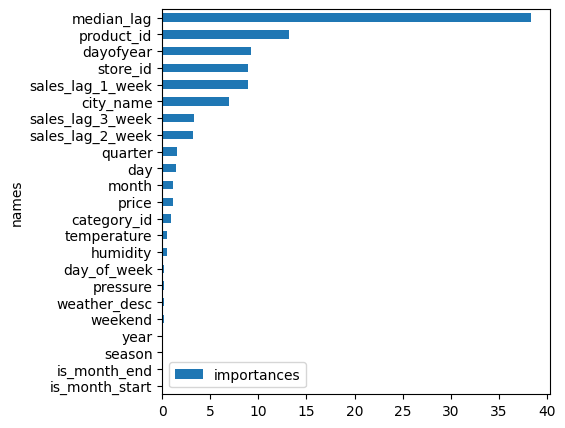

In [ ]:
pd.DataFrame(
    {"importances": model_cb.feature_importances_, "names": model_cb.feature_names_}
).sort_values("importances")[-30:].plot.barh(y="importances", x="names", figsize=(5, 5))

### LightGBM model

In [ ]:
params = dict(
    objective="tweedie",
    metric="None",
    learning_rate=0.05,
    max_depth=11,
    boosting_type="gbdt",
    num_leaves=30,
    n_estimators=200,
    n_jobs=8,
    random_state=11,
)

params.update(best_params_lgb)

model_lgb = lgb.LGBMRegressor(**params)

In [ ]:
def custom_metric(y_pred: np.ndarray, y_true: np.ndarray):
    """_summary_

    Args:
        y_pred (np.ndarray): _description_
        y_true (np.ndarray): _description_

    Returns:
        Tuple[str, float, bool]: _description_
    """  # TODO: describe

    return "wape", wape_f(y_true, y_pred), False

In [ ]:
city_list = train_df.city_name.unique().tolist()
waether_list = train_df.weather_desc.unique().tolist()
days_list = train_df.day_of_week.unique().tolist()
season_list = train_df.season.unique().tolist()

for df in [train_df, eval_df, test_df]:

    df["city_name"].replace(city_list, range(len(city_list)), inplace=True)
    df["weather_desc"].replace(waether_list, range(len(waether_list)), inplace=True)
    df["day_of_week"].replace(days_list, range(len(days_list)), inplace=True)
    df["season"].replace(season_list, range(len(season_list)), inplace=True)

In [ ]:
fit_params = dict(
    X=train_df.drop(columns="sales"),
    y=train_df.sales,
    categorical_feature=cat_feats,
)

d_eval = dict(
    eval_set=(eval_df.drop(columns="sales"), eval_df.sales),
    eval_names="eval_df",
    eval_metric=custom_metric,
    callbacks=[
        lgb.log_evaluation(),
        lgb.early_stopping(stopping_rounds=30, verbose=True),
    ],
)

fit_params.update(d_eval)


model_lgb.fit(**fit_params)

In [ ]:
test_df["predicted_lgb"] = model_lgb.predict(test_df.drop(columns="sales"))

In [ ]:
wape_f(test_df["sales"], test_df["predicted_lgb"])

32.007

In [ ]:
sample = test_df[
    (test_df.store_id == 1)
    & (test_df.product_id == 1)
    & (test_df.day > test_df.day.min())
].reset_index(drop=True)

fig = go.Figure(
    [
        go.Scatter(
            x=sample.index,
            y=sample.sales,
            name="True values",
            mode="lines+markers",
            marker_color="rgba(0, 0, 0, .6)",
            # showlegend=False,
        ),
        go.Scatter(
            x=sample.index,
            y=sample.predicted_lgb,
            name="Predicted",
            # opacity=0.6,
            mode="lines+markers",
        ),
    ]
)
# modify layout of the graph
fig.update_layout(
    title={
        "text": "Predictions of ML model",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    margin=dict(l=40, r=10, t=40, b=40),
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-0.2,
        xanchor="center",
        x=0.5,
    ),
    xaxis_title="Days",
    yaxis_title="Sales",
    height=400,
    width=700,
)
fig.show()

## Results

- Compared two popular gradient boosting models (LightGBM and CatBoost).
- Models demonstrated similar accuracy metrics of test dataframe. 
- However, LightGBM was significantly faster to train and tune; and slightly more accurate